In [41]:
from tensorflow.keras.models import load_model
from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel
from sklearn.preprocessing import LabelEncoder
import numpy as np
from glob import glob
import argparse
import os
import pandas as pd
from tqdm import tqdm
import wavio
import matplotlib.pyplot as plt
from scipy.io import wavfile
import argparse
import pandas as pd
from librosa.core import resample, to_mono
from sklearn.metrics import precision_score, f1_score
from tensorflow.keras.utils import to_categorical

def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean


def downsample_mono(path, sr):
    obj = wavio.read(path)
    wav = obj.data.astype(np.float32, order='F')
    rate = obj.rate
    try:
        channel = wav.shape[1]
        if channel == 2:
            wav = to_mono(wav.T)
        elif channel == 1:
            wav = to_mono(wav.reshape(-1))
    except IndexError:
        wav = to_mono(wav.reshape(-1))
        pass
    except Exception as exc:
        raise exc
    wav = resample(wav, orig_sr=rate, target_sr=sr)
    wav = wav.astype(np.int16)
    return sr, wav


def make_prediction(args):

    model = load_model(args.model_fn,
        custom_objects={'STFT':STFT,
                        'Magnitude':Magnitude,
                        'ApplyFilterbank':ApplyFilterbank,
                        'MagnitudeToDecibel':MagnitudeToDecibel})
    wav_paths = glob('{}/**'.format(args.src_dir), recursive=True)
    wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x])
    classes = sorted(os.listdir(args.src_dir))
    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
    le = LabelEncoder()
    y_true = le.fit_transform(labels)
    results = []

    for z, wav_fn in tqdm(enumerate(wav_paths), total=len(wav_paths)):
        rate, wav = downsample_mono(wav_fn, args.sr)
        mask, env = envelope(wav, rate, threshold=args.threshold)
        clean_wav = wav[mask]
        step = int(args.sr*args.dt)
        batch = []

        for i in range(0, clean_wav.shape[0], step):
            sample = clean_wav[i:i+step]
            sample = sample.reshape(-1, 1)
            if sample.shape[0] < step:
                tmp = np.zeros(shape=(step, 1), dtype=np.float32)
                tmp[:sample.shape[0],:] = sample.flatten().reshape(-1, 1)
                sample = tmp
            batch.append(sample)
        X_batch = np.array(batch, dtype=np.float32)
        y_pred = model.predict(X_batch)
        y_mean = np.mean(y_pred, axis=0)
        y_pred = np.argmax(y_mean)
        real_class = os.path.dirname(wav_fn).split('/')[-1]
        print('Actual class: {}, Predicted class: {}'.format(real_class, classes[y_pred]))
        results.append(y_mean)

    np.save(os.path.join('logs', args.pred_fn), np.array(results))


if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Audio Classification Training')
    parser.add_argument('--model_fn', type=str, default='/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/models/lstm.h5',
                        help='model file to make predictions')
    parser.add_argument('--pred_fn', type=str, default='/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/logs/y_pred',
                        help='fn to write predictions in logs dir')
    parser.add_argument('--src_dir', type=str, default='/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/instrument_classification',
                        help='directory containing wavfiles to predict')
    parser.add_argument('--dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sr', type=int, default=16000,
                        help='sample rate of clean audio')
    parser.add_argument('--threshold', type=str, default=20,
                        help='threshold magnitude for np.int16 dtype')
    args, _ = parser.parse_known_args()

    make_prediction(args)


  0%|                                                  | 0/2913 [00:00<?, ?it/s]

1/1 [==============================] - 0s 310ms/step


  0%|                                          | 1/2913 [00:00<16:25,  2.95it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  0%|                                          | 4/2913 [00:00<04:48, 10.09it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  0%|                                          | 7/2913 [00:00<03:20, 14.46it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  0%|▏                                        | 10/2913 [00:00<02:51, 16.88it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 30ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 32ms/step


  0%|▏                                        | 12/2913 [00:00<03:02, 15.86it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


  0%|▏                                        | 14/2913 [00:01<03:04, 15.72it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  1%|▏                                        | 17/2913 [00:01<02:43, 17.76it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 21ms/step


  1%|▎                                        | 19/2913 [00:01<02:39, 18.15it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  1%|▎                                        | 22/2913 [00:01<02:28, 19.45it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  1%|▎                                        | 25/2913 [00:01<02:21, 20.38it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 22ms/step


  1%|▍                                        | 28/2913 [00:01<02:48, 17.14it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 20ms/step


  1%|▍                                        | 30/2913 [00:01<02:43, 17.60it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  1%|▍                                        | 32/2913 [00:01<02:39, 18.09it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  1%|▍                                        | 35/2913 [00:02<02:24, 19.89it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step


  1%|▌                                        | 38/2913 [00:02<02:20, 20.49it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  1%|▌                                        | 41/2913 [00:02<02:15, 21.16it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


  2%|▌                                        | 44/2913 [00:02<02:16, 21.04it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  2%|▋                                        | 47/2913 [00:02<02:15, 21.13it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step


  2%|▋                                        | 50/2913 [00:02<02:13, 21.47it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  2%|▋                                        | 53/2913 [00:02<02:10, 21.89it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 12ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  2%|▊                                        | 56/2913 [00:03<02:05, 22.83it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  2%|▊                                        | 59/2913 [00:03<02:04, 22.88it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  2%|▊                                        | 62/2913 [00:03<02:05, 22.70it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  2%|▉                                        | 65/2913 [00:03<02:03, 23.05it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


  2%|▉                                        | 68/2913 [00:03<02:05, 22.76it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


  2%|▉                                        | 71/2913 [00:03<02:05, 22.62it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 24ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step


  3%|█                                        | 74/2913 [00:03<02:10, 21.70it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  3%|█                                        | 77/2913 [00:03<02:07, 22.25it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  3%|█▏                                       | 80/2913 [00:04<02:03, 22.85it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  3%|█▏                                       | 83/2913 [00:04<02:03, 22.83it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  3%|█▏                                       | 86/2913 [00:04<02:05, 22.56it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  3%|█▎                                       | 89/2913 [00:04<02:07, 22.22it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


  3%|█▎                                       | 92/2913 [00:04<02:06, 22.35it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


  3%|█▎                                       | 95/2913 [00:04<02:08, 21.86it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  3%|█▍                                       | 98/2913 [00:04<02:06, 22.25it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  3%|█▍                                      | 101/2913 [00:05<02:04, 22.59it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  4%|█▍                                      | 104/2913 [00:05<02:03, 22.82it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  4%|█▍                                      | 107/2913 [00:05<02:01, 23.07it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  4%|█▌                                      | 110/2913 [00:05<02:04, 22.57it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  4%|█▌                                      | 113/2913 [00:05<02:02, 22.77it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 20ms/step


  4%|█▌                                      | 116/2913 [00:05<02:29, 18.68it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 119/2913 [00:05<02:21, 19.81it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 122/2913 [00:06<02:13, 20.90it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  4%|█▋                                      | 125/2913 [00:06<02:08, 21.65it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  4%|█▊                                      | 128/2913 [00:06<02:03, 22.63it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 22ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  4%|█▊                                      | 131/2913 [00:06<02:06, 22.05it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  5%|█▊                                      | 134/2913 [00:06<02:04, 22.35it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  5%|█▉                                      | 137/2913 [00:06<02:02, 22.73it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 21ms/step


  5%|█▉                                      | 140/2913 [00:06<02:03, 22.45it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  5%|█▉                                      | 143/2913 [00:06<02:00, 23.01it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  5%|██                                      | 146/2913 [00:07<01:55, 23.88it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 149/2913 [00:07<01:56, 23.67it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  5%|██                                      | 152/2913 [00:07<01:56, 23.72it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  5%|██▏                                     | 155/2913 [00:07<01:59, 23.08it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  5%|██▏                                     | 158/2913 [00:07<02:06, 21.72it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  6%|██▏                                     | 161/2913 [00:07<02:03, 22.36it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  6%|██▎                                     | 164/2913 [00:07<02:04, 22.07it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


  6%|██▎                                     | 167/2913 [00:08<02:08, 21.29it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  6%|██▎                                     | 170/2913 [00:08<02:07, 21.52it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  6%|██▍                                     | 173/2913 [00:08<02:04, 22.04it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 176/2913 [00:08<02:02, 22.33it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  6%|██▍                                     | 179/2913 [00:08<02:00, 22.72it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  6%|██▍                                     | 182/2913 [00:08<01:58, 23.01it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  6%|██▌                                     | 185/2913 [00:08<01:55, 23.63it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  6%|██▌                                     | 188/2913 [00:08<01:58, 23.09it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  7%|██▌                                     | 191/2913 [00:09<01:56, 23.40it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  7%|██▋                                     | 194/2913 [00:09<01:54, 23.70it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  7%|██▋                                     | 197/2913 [00:09<01:53, 23.83it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  7%|██▋                                     | 200/2913 [00:09<01:51, 24.32it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  7%|██▊                                     | 203/2913 [00:09<01:52, 24.09it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 12ms/step


  7%|██▊                                     | 206/2913 [00:09<01:48, 25.00it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  7%|██▊                                     | 209/2913 [00:09<01:50, 24.38it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 212/2913 [00:09<01:51, 24.28it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  7%|██▉                                     | 215/2913 [00:10<01:53, 23.80it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  7%|██▉                                     | 218/2913 [00:10<01:51, 24.14it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step


  8%|███                                     | 221/2913 [00:10<01:50, 24.39it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  8%|███                                     | 224/2913 [00:10<01:51, 24.18it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  8%|███                                     | 227/2913 [00:10<01:52, 23.78it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  8%|███▏                                    | 230/2913 [00:10<01:51, 24.11it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  8%|███▏                                    | 233/2913 [00:10<01:53, 23.63it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 36ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  8%|███▏                                    | 236/2913 [00:10<01:58, 22.53it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  8%|███▎                                    | 239/2913 [00:11<01:57, 22.68it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 21ms/step


  8%|███▎                                    | 242/2913 [00:11<02:01, 22.05it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  8%|███▎                                    | 245/2913 [00:11<01:58, 22.52it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  9%|███▍                                    | 248/2913 [00:11<01:57, 22.71it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  9%|███▍                                    | 251/2913 [00:11<01:53, 23.52it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 58ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 20ms/step


  9%|███▍                                    | 254/2913 [00:11<02:20, 18.92it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


  9%|███▌                                    | 257/2913 [00:11<02:12, 20.01it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  9%|███▌                                    | 260/2913 [00:12<02:08, 20.69it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  9%|███▌                                    | 263/2913 [00:12<02:01, 21.90it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion


  9%|███▋                                    | 266/2913 [00:12<01:57, 22.47it/s]

1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


  9%|███▋                                    | 269/2913 [00:12<01:58, 22.29it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


  9%|███▋                                    | 272/2913 [00:12<01:57, 22.52it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


  9%|███▊                                    | 275/2913 [00:12<01:54, 22.99it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 10%|███▊                                    | 278/2913 [00:12<01:54, 23.10it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 10%|███▊                                    | 281/2913 [00:12<01:51, 23.55it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 10%|███▉                                    | 284/2913 [00:13<01:51, 23.49it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 10%|███▉                                    | 287/2913 [00:13<01:50, 23.77it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 130ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 10%|███▉                                    | 290/2913 [00:13<02:21, 18.48it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 10%|████                                    | 293/2913 [00:13<02:10, 20.13it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 10%|████                                    | 296/2913 [00:13<02:04, 21.04it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 10%|████                                    | 299/2913 [00:13<01:59, 21.88it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 10%|████▏                                   | 302/2913 [00:13<01:56, 22.44it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 10%|████▏                                   | 305/2913 [00:14<02:48, 15.51it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 11%|████▏                                   | 308/2913 [00:14<02:32, 17.07it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 11%|████▎                                   | 311/2913 [00:14<02:17, 18.94it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 11%|████▎                                   | 314/2913 [00:14<02:08, 20.18it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 11%|████▎                                   | 317/2913 [00:14<02:02, 21.27it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step


 11%|████▍                                   | 320/2913 [00:14<01:57, 22.16it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 11%|████▍                                   | 323/2913 [00:15<01:52, 23.10it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 11%|████▍                                   | 326/2913 [00:15<01:53, 22.82it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 11%|████▌                                   | 329/2913 [00:15<01:50, 23.32it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 11%|████▌                                   | 332/2913 [00:15<01:49, 23.47it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 12%|████▌                                   | 335/2913 [00:15<01:52, 22.98it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 12%|████▋                                   | 338/2913 [00:15<01:51, 23.13it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


 12%|████▋                                   | 341/2913 [00:15<01:51, 23.06it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 12%|████▋                                   | 344/2913 [00:15<01:51, 22.96it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 113ms/step


 12%|████▊                                   | 347/2913 [00:16<02:21, 18.15it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 12%|████▊                                   | 350/2913 [00:16<02:11, 19.49it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 12%|████▊                                   | 353/2913 [00:16<02:03, 20.72it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 12%|████▉                                   | 356/2913 [00:16<02:01, 21.12it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 12%|████▉                                   | 359/2913 [00:16<01:58, 21.54it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 12%|████▉                                   | 362/2913 [00:16<01:54, 22.18it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 13%|█████                                   | 365/2913 [00:16<01:51, 22.78it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 13%|█████                                   | 368/2913 [00:17<01:48, 23.38it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 13%|█████                                   | 371/2913 [00:17<01:54, 22.15it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 13%|█████▏                                  | 374/2913 [00:17<01:52, 22.57it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 13%|█████▏                                  | 377/2913 [00:17<01:54, 22.17it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


 13%|█████▏                                  | 380/2913 [00:17<01:52, 22.43it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                  | 383/2913 [00:17<01:53, 22.36it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 13%|█████▎                                  | 386/2913 [00:17<01:51, 22.63it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 13%|█████▎                                  | 389/2913 [00:18<01:50, 22.86it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 13%|█████▍                                  | 392/2913 [00:18<01:48, 23.30it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 14%|█████▍                                  | 395/2913 [00:18<01:46, 23.66it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 20ms/step


 14%|█████▍                                  | 398/2913 [00:18<01:51, 22.56it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 14%|█████▌                                  | 401/2913 [00:18<01:50, 22.83it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 14%|█████▌                                  | 404/2913 [00:18<01:47, 23.26it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 14%|█████▌                                  | 407/2913 [00:18<01:47, 23.24it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 21ms/step


 14%|█████▋                                  | 410/2913 [00:18<01:51, 22.38it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 14%|█████▋                                  | 413/2913 [00:19<01:51, 22.36it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 14%|█████▋                                  | 416/2913 [00:19<01:49, 22.79it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 14%|█████▊                                  | 419/2913 [00:19<01:48, 23.08it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 14%|█████▊                                  | 422/2913 [00:19<01:47, 23.12it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 15%|█████▊                                  | 425/2913 [00:19<01:47, 23.13it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 15%|█████▉                                  | 428/2913 [00:19<01:47, 23.14it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 15%|█████▉                                  | 431/2913 [00:19<01:45, 23.54it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 15%|█████▉                                  | 434/2913 [00:19<01:45, 23.45it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 15%|██████                                  | 437/2913 [00:20<01:43, 23.97it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 15%|██████                                  | 440/2913 [00:20<01:42, 24.03it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 15%|██████                                  | 443/2913 [00:20<01:43, 23.92it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 15%|██████                                  | 446/2913 [00:20<01:41, 24.28it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 15%|██████▏                                 | 449/2913 [00:20<01:41, 24.36it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 16%|██████▏                                 | 452/2913 [00:20<01:47, 22.88it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 16%|██████▏                                 | 455/2913 [00:20<01:45, 23.36it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 16%|██████▎                                 | 458/2913 [00:20<01:43, 23.78it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 16%|██████▎                                 | 461/2913 [00:21<01:43, 23.74it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


 16%|██████▎                                 | 464/2913 [00:21<01:44, 23.47it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 25ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 16%|██████▍                                 | 467/2913 [00:21<01:51, 22.03it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 16%|██████▍                                 | 470/2913 [00:21<01:47, 22.83it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 16%|██████▍                                 | 473/2913 [00:21<01:45, 23.04it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 22ms/step


 16%|██████▌                                 | 476/2913 [00:21<01:48, 22.36it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 16%|██████▌                                 | 479/2913 [00:21<01:46, 22.83it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 17%|██████▌                                 | 482/2913 [00:22<01:45, 23.02it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 17%|██████▋                                 | 485/2913 [00:22<01:44, 23.15it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 17%|██████▋                                 | 488/2913 [00:22<01:44, 23.15it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 17%|██████▋                                 | 491/2913 [00:22<01:44, 23.26it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                 | 494/2913 [00:22<01:43, 23.30it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 17%|██████▊                                 | 497/2913 [00:22<01:42, 23.58it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 17%|██████▊                                 | 500/2913 [00:22<01:42, 23.61it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 17%|██████▉                                 | 503/2913 [00:22<01:42, 23.53it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 17%|██████▉                                 | 506/2913 [00:23<01:42, 23.38it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 17%|██████▉                                 | 509/2913 [00:23<01:40, 23.82it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 18%|███████                                 | 512/2913 [00:23<01:40, 23.91it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 18%|███████                                 | 515/2913 [00:23<01:40, 23.86it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 18%|███████                                 | 518/2913 [00:23<01:39, 24.09it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 18%|███████▏                                | 521/2913 [00:23<01:41, 23.59it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 18%|███████▏                                | 524/2913 [00:23<01:40, 23.80it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 18%|███████▏                                | 527/2913 [00:23<01:44, 22.76it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 21ms/step


 18%|███████▎                                | 530/2913 [00:24<01:46, 22.36it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 18%|███████▎                                | 533/2913 [00:24<01:45, 22.66it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 21ms/step


 18%|███████▎                                | 536/2913 [00:24<01:48, 21.99it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 19%|███████▍                                | 539/2913 [00:24<01:46, 22.29it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 19%|███████▍                                | 542/2913 [00:24<01:45, 22.53it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step


 19%|███████▍                                | 545/2913 [00:24<01:43, 22.81it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 19%|███████▌                                | 548/2913 [00:24<01:43, 22.89it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 19%|███████▌                                | 551/2913 [00:24<01:40, 23.46it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 19%|███████▌                                | 554/2913 [00:25<01:39, 23.76it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 19%|███████▋                                | 557/2913 [00:25<01:38, 23.89it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 19%|███████▋                                | 560/2913 [00:25<01:38, 23.99it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 19%|███████▋                                | 563/2913 [00:25<01:38, 23.94it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 19%|███████▊                                | 566/2913 [00:25<01:40, 23.39it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 20%|███████▊                                | 569/2913 [00:25<01:41, 23.13it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 20%|███████▊                                | 572/2913 [00:25<01:39, 23.46it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 20%|███████▉                                | 575/2913 [00:26<01:39, 23.54it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step


 20%|███████▉                                | 578/2913 [00:26<01:38, 23.71it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 20%|███████▉                                | 581/2913 [00:26<01:39, 23.52it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 20%|████████                                | 584/2913 [00:26<01:38, 23.57it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 20%|████████                                | 587/2913 [00:26<01:39, 23.46it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 21ms/step


 20%|████████                                | 590/2913 [00:26<01:40, 23.01it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 20%|████████▏                               | 593/2913 [00:26<01:42, 22.59it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 13ms/step


 20%|████████▏                               | 596/2913 [00:26<01:40, 22.97it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 34ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 21%|████████▏                               | 599/2913 [00:27<01:43, 22.34it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 20ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 21%|████████▎                               | 602/2913 [00:27<01:45, 21.95it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 21%|████████▎                               | 605/2913 [00:27<01:43, 22.35it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 21%|████████▎                               | 608/2913 [00:27<01:41, 22.80it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 21%|████████▍                               | 611/2913 [00:27<01:39, 23.24it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 21%|████████▍                               | 614/2913 [00:27<01:40, 22.91it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 21%|████████▍                               | 617/2913 [00:27<01:37, 23.44it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 21%|████████▌                               | 620/2913 [00:27<01:37, 23.45it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


 21%|████████▌                               | 623/2913 [00:28<01:38, 23.22it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 21%|████████▌                               | 626/2913 [00:28<01:38, 23.14it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 22%|████████▋                               | 629/2913 [00:28<01:37, 23.38it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 22%|████████▋                               | 632/2913 [00:28<01:39, 22.99it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 22%|████████▋                               | 635/2913 [00:28<01:38, 23.21it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 22%|████████▊                               | 638/2913 [00:28<01:37, 23.32it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 22%|████████▊                               | 641/2913 [00:28<01:39, 22.88it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 22%|████████▊                               | 644/2913 [00:29<01:39, 22.73it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 25ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 22%|████████▉                               | 647/2913 [00:29<01:45, 21.57it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step


 22%|████████▉                               | 650/2913 [00:29<01:44, 21.66it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step


 22%|████████▉                               | 653/2913 [00:29<01:44, 21.67it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step


 23%|█████████                               | 656/2913 [00:29<01:45, 21.45it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 25ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 23%|█████████                               | 659/2913 [00:29<01:49, 20.68it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 23%|█████████                               | 662/2913 [00:29<01:45, 21.29it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 23%|█████████▏                              | 665/2913 [00:30<01:47, 20.84it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 23%|█████████▏                              | 668/2913 [00:30<01:43, 21.73it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 18ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 23%|█████████▏                              | 671/2913 [00:30<01:41, 22.14it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 23%|█████████▎                              | 674/2913 [00:30<01:40, 22.20it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 23%|█████████▎                              | 677/2913 [00:30<01:38, 22.78it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 23%|█████████▎                              | 680/2913 [00:30<01:37, 22.95it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 16ms/step


 23%|█████████▍                              | 683/2913 [00:30<01:37, 22.99it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 24%|█████████▍                              | 686/2913 [00:30<01:35, 23.22it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 17ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 14ms/step


 24%|█████████▍                              | 689/2913 [00:31<01:35, 23.30it/s]

Actual class: Accordion, Predicted class: Accordion
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step


 24%|█████████▌                              | 693/2913 [00:31<01:25, 26.07it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 11ms/step
Actual class: Bass_Tuba, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 24%|█████████▌                              | 697/2913 [00:31<01:20, 27.47it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step


 24%|█████████▋                              | 701/2913 [00:31<01:17, 28.54it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step


 24%|█████████▋                              | 705/2913 [00:31<01:15, 29.36it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step


 24%|█████████▋                              | 709/2913 [00:31<01:14, 29.55it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step


 24%|█████████▊                              | 713/2913 [00:31<01:13, 30.00it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step


 25%|█████████▊                              | 717/2913 [00:31<01:11, 30.68it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step


 25%|█████████▉                              | 721/2913 [00:32<01:11, 30.46it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step


 25%|█████████▉                              | 725/2913 [00:32<01:11, 30.43it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step


 25%|██████████                              | 729/2913 [00:32<01:09, 31.29it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step


 25%|██████████                              | 733/2913 [00:32<01:10, 30.94it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step


 25%|██████████                              | 737/2913 [00:32<01:13, 29.49it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 17ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step


 25%|██████████▏                             | 740/2913 [00:32<01:13, 29.52it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step


 26%|██████████▏                             | 744/2913 [00:32<01:11, 30.24it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step


 26%|██████████▎                             | 748/2913 [00:32<01:11, 30.11it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step


 26%|██████████▎                             | 752/2913 [00:33<01:11, 30.33it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step


 26%|██████████▍                             | 756/2913 [00:33<01:09, 30.94it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step


 26%|██████████▍                             | 760/2913 [00:33<01:10, 30.71it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step


 26%|██████████▍                             | 764/2913 [00:33<01:08, 31.30it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step


 26%|██████████▌                             | 768/2913 [00:33<01:08, 31.19it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step


 27%|██████████▌                             | 772/2913 [00:33<01:09, 30.97it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step


 27%|██████████▋                             | 776/2913 [00:33<01:08, 30.99it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Accordion
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step


 27%|██████████▋                             | 780/2913 [00:33<01:07, 31.57it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step


 27%|██████████▊                             | 784/2913 [00:34<01:08, 30.99it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step


 27%|██████████▊                             | 788/2913 [00:34<01:09, 30.69it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 12ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step


 27%|██████████▉                             | 792/2913 [00:34<01:07, 31.31it/s]

Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 14ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 13ms/step
Actual class: Bass_Tuba, Predicted class: Accordion
1/1 [==============================] - 0s 38ms/step


 27%|██████████▉                             | 796/2913 [00:34<01:12, 29.07it/s]

Actual class: Bass_Tuba, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Bass_Tuba, Predicted class: Bass_Tuba
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 27%|██████████▉                             | 799/2913 [00:34<01:15, 27.91it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 28%|███████████                             | 802/2913 [00:34<01:18, 26.74it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 28%|███████████                             | 805/2913 [00:34<01:21, 26.02it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step


 28%|███████████                             | 808/2913 [00:35<01:22, 25.53it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 32ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 28%|███████████▏                            | 811/2913 [00:35<01:31, 22.99it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 28%|███████████▏                            | 814/2913 [00:35<01:29, 23.38it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 28%|███████████▏                            | 817/2913 [00:35<01:29, 23.50it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 19ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 19ms/step


 28%|███████████▎                            | 820/2913 [00:35<01:30, 23.06it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 28%|███████████▎                            | 823/2913 [00:35<01:30, 23.16it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step


 28%|███████████▎                            | 826/2913 [00:35<01:28, 23.46it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 28%|███████████▍                            | 829/2913 [00:35<01:28, 23.66it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 29%|███████████▍                            | 832/2913 [00:36<01:28, 23.49it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 29%|███████████▍                            | 835/2913 [00:36<01:27, 23.71it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 29%|███████████▌                            | 838/2913 [00:36<01:27, 23.68it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step


 29%|███████████▌                            | 841/2913 [00:36<01:28, 23.54it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 29%|███████████▌                            | 844/2913 [00:36<01:32, 22.31it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 29%|███████████▋                            | 847/2913 [00:36<01:30, 22.75it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step


 29%|███████████▋                            | 850/2913 [00:36<01:28, 23.23it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step


 29%|███████████▋                            | 853/2913 [00:36<01:27, 23.48it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step


 29%|███████████▊                            | 856/2913 [00:37<01:31, 22.43it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step


 29%|███████████▊                            | 859/2913 [00:37<01:29, 23.01it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step


 30%|███████████▊                            | 862/2913 [00:37<01:27, 23.51it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step


 30%|███████████▉                            | 865/2913 [00:37<01:26, 23.72it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 30%|███████████▉                            | 868/2913 [00:37<01:26, 23.71it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 30%|███████████▉                            | 871/2913 [00:37<01:26, 23.71it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 30%|████████████                            | 874/2913 [00:37<01:25, 23.90it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step


 30%|████████████                            | 877/2913 [00:38<01:25, 23.71it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 39ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 30%|████████████                            | 880/2913 [00:38<01:31, 22.22it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step


 30%|████████████                            | 883/2913 [00:38<01:29, 22.72it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 20ms/step


 30%|████████████▏                           | 886/2913 [00:38<01:29, 22.59it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 19ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 31%|████████████▏                           | 889/2913 [00:38<01:29, 22.65it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 19ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step


 31%|████████████▏                           | 892/2913 [00:38<01:29, 22.62it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 31%|████████████▎                           | 895/2913 [00:38<01:28, 22.84it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 31%|████████████▎                           | 898/2913 [00:38<01:27, 23.00it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 19ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 31%|████████████▎                           | 901/2913 [00:39<01:27, 23.01it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 31%|████████████▍                           | 904/2913 [00:39<01:26, 23.25it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 19ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 31%|████████████▍                           | 907/2913 [00:39<01:25, 23.33it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 31%|████████████▍                           | 910/2913 [00:39<01:25, 23.34it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 15ms/step


 31%|████████████▌                           | 913/2913 [00:39<01:24, 23.64it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step


 31%|████████████▌                           | 916/2913 [00:39<01:23, 23.97it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 16ms/step


 32%|████████████▌                           | 919/2913 [00:39<01:23, 23.95it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 17ms/step


 32%|████████████▋                           | 922/2913 [00:39<01:22, 24.07it/s]

Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 18ms/step
Actual class: Bassoon, Predicted class: Bassoon
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 32%|████████████▋                           | 925/2913 [00:40<01:24, 23.44it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 32%|████████████▋                           | 928/2913 [00:40<01:26, 22.93it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 32%|████████████▊                           | 931/2913 [00:40<01:28, 22.37it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 17ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 32%|████████████▊                           | 934/2913 [00:40<01:28, 22.26it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 32%|████████████▊                           | 937/2913 [00:40<01:28, 22.33it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 32%|████████████▉                           | 940/2913 [00:40<01:29, 22.08it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 32%|████████████▉                           | 943/2913 [00:40<01:30, 21.80it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 32%|████████████▉                           | 946/2913 [00:41<01:34, 20.91it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step


 33%|█████████████                           | 949/2913 [00:41<01:33, 20.94it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 17ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 33%|█████████████                           | 952/2913 [00:41<01:31, 21.47it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 33%|█████████████                           | 955/2913 [00:41<01:30, 21.61it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step


 33%|█████████████▏                          | 958/2913 [00:41<01:31, 21.36it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 33%|█████████████▏                          | 961/2913 [00:41<01:30, 21.62it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 33%|█████████████▏                          | 964/2913 [00:41<01:30, 21.50it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 33%|█████████████▎                          | 967/2913 [00:42<01:30, 21.60it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 33%|█████████████▎                          | 970/2913 [00:42<01:29, 21.75it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 33%|█████████████▎                          | 973/2913 [00:42<01:28, 21.99it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 34%|█████████████▍                          | 976/2913 [00:42<01:28, 21.99it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 34%|█████████████▍                          | 979/2913 [00:42<01:28, 21.78it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 34%|█████████████▍                          | 982/2913 [00:42<01:28, 21.92it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 16ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 34%|█████████████▌                          | 985/2913 [00:42<01:27, 22.10it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 34%|█████████████▌                          | 988/2913 [00:42<01:27, 22.13it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 34%|█████████████▌                          | 991/2913 [00:43<01:27, 21.96it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 17ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 34%|█████████████▋                          | 994/2913 [00:43<01:26, 22.11it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 34%|█████████████▋                          | 997/2913 [00:43<01:27, 21.95it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step


 34%|█████████████▍                         | 1000/2913 [00:43<01:27, 21.84it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 17ms/step


 34%|█████████████▍                         | 1003/2913 [00:43<01:27, 21.87it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 35%|█████████████▍                         | 1006/2913 [00:43<01:26, 21.93it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 17ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 35%|█████████████▌                         | 1009/2913 [00:43<01:26, 22.04it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 17ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step


 35%|█████████████▌                         | 1012/2913 [00:44<01:30, 21.11it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 35%|█████████████▌                         | 1015/2913 [00:44<01:28, 21.52it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 17ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step


 35%|█████████████▋                         | 1018/2913 [00:44<01:27, 21.71it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 35%|█████████████▋                         | 1021/2913 [00:44<01:27, 21.73it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 35%|█████████████▋                         | 1024/2913 [00:44<01:27, 21.59it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 35%|█████████████▋                         | 1027/2913 [00:44<01:27, 21.58it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 35%|█████████████▊                         | 1030/2913 [00:44<01:27, 21.44it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 35%|█████████████▊                         | 1033/2913 [00:45<01:26, 21.72it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 36%|█████████████▊                         | 1036/2913 [00:45<01:27, 21.56it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 36%|█████████████▉                         | 1039/2913 [00:45<01:27, 21.46it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 36%|█████████████▉                         | 1042/2913 [00:45<01:27, 21.46it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step


 36%|█████████████▉                         | 1045/2913 [00:45<01:26, 21.58it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 20ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 19ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step


 36%|██████████████                         | 1048/2913 [00:45<01:27, 21.34it/s]

Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 18ms/step
Actual class: Clarinet_Bb, Predicted class: Clarinet_Bb
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 36%|██████████████                         | 1051/2913 [00:45<01:25, 21.72it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 20ms/step


 36%|██████████████                         | 1054/2913 [00:46<01:27, 21.19it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 36%|██████████████▏                        | 1057/2913 [00:46<01:25, 21.71it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 36%|██████████████▏                        | 1060/2913 [00:46<01:20, 22.92it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 36%|██████████████▏                        | 1063/2913 [00:46<01:19, 23.37it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 37%|██████████████▎                        | 1066/2913 [00:46<01:19, 23.22it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step


 37%|██████████████▎                        | 1069/2913 [00:46<01:16, 24.01it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 37%|██████████████▎                        | 1072/2913 [00:46<01:14, 24.59it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 37%|██████████████▍                        | 1075/2913 [00:46<01:12, 25.23it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 21ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step


 37%|██████████████▍                        | 1078/2913 [00:47<01:20, 22.86it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step


 37%|██████████████▍                        | 1081/2913 [00:47<01:24, 21.62it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 20ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 1084/2913 [00:47<01:24, 21.72it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step


 37%|██████████████▌                        | 1087/2913 [00:47<01:22, 22.18it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 37%|██████████████▌                        | 1090/2913 [00:47<01:20, 22.72it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 38%|██████████████▋                        | 1093/2913 [00:47<01:19, 22.82it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 38%|██████████████▋                        | 1096/2913 [00:47<01:18, 23.19it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 38%|██████████████▋                        | 1099/2913 [00:47<01:16, 23.67it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 38%|██████████████▊                        | 1102/2913 [00:48<01:13, 24.50it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step


 38%|██████████████▊                        | 1105/2913 [00:48<01:14, 24.19it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 20ms/step


 38%|██████████████▊                        | 1108/2913 [00:48<01:18, 22.90it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 38%|██████████████▊                        | 1111/2913 [00:48<01:18, 23.09it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 1114/2913 [00:48<01:16, 23.47it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 38%|██████████████▉                        | 1117/2913 [00:48<01:15, 23.73it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 38%|██████████████▉                        | 1120/2913 [00:48<01:17, 23.10it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 39%|███████████████                        | 1123/2913 [00:48<01:16, 23.33it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 39%|███████████████                        | 1126/2913 [00:49<01:15, 23.57it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 39%|███████████████                        | 1129/2913 [00:49<01:13, 24.44it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 39%|███████████████▏                       | 1132/2913 [00:49<01:11, 25.02it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step


 39%|███████████████▏                       | 1135/2913 [00:49<01:12, 24.39it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 39%|███████████████▏                       | 1138/2913 [00:49<01:11, 24.77it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 39%|███████████████▎                       | 1141/2913 [00:49<01:09, 25.32it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 39%|███████████████▎                       | 1144/2913 [00:49<01:12, 24.45it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step


 39%|███████████████▎                       | 1147/2913 [00:49<01:14, 23.80it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step


 39%|███████████████▍                       | 1150/2913 [00:50<01:11, 24.62it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 40%|███████████████▍                       | 1153/2913 [00:50<01:11, 24.60it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 40%|███████████████▍                       | 1156/2913 [00:50<01:10, 24.76it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step


 40%|███████████████▌                       | 1159/2913 [00:50<01:11, 24.40it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 40%|███████████████▌                       | 1162/2913 [00:50<01:11, 24.43it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 40%|███████████████▌                       | 1165/2913 [00:50<01:10, 24.89it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 40%|███████████████▋                       | 1168/2913 [00:50<01:09, 25.07it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 40%|███████████████▋                       | 1171/2913 [00:50<01:09, 24.90it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 40%|███████████████▋                       | 1174/2913 [00:51<01:08, 25.37it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 40%|███████████████▊                       | 1177/2913 [00:51<01:07, 25.65it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 41%|███████████████▊                       | 1180/2913 [00:51<01:06, 26.13it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 41%|███████████████▊                       | 1183/2913 [00:51<01:06, 25.89it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step


 41%|███████████████▉                       | 1186/2913 [00:51<01:09, 24.90it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step


 41%|███████████████▉                       | 1189/2913 [00:51<01:11, 24.00it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 41%|███████████████▉                       | 1192/2913 [00:51<01:10, 24.50it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 41%|███████████████▉                       | 1195/2913 [00:51<01:08, 24.99it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 41%|████████████████                       | 1198/2913 [00:52<01:08, 25.09it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 41%|████████████████                       | 1201/2913 [00:52<01:10, 24.33it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 41%|████████████████                       | 1204/2913 [00:52<01:08, 24.94it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 21ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 41%|████████████████▏                      | 1207/2913 [00:52<01:12, 23.50it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 21ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step


 42%|████████████████▏                      | 1210/2913 [00:52<01:18, 21.60it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 23ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step


 42%|████████████████▏                      | 1213/2913 [00:52<01:21, 20.86it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 1216/2913 [00:52<01:18, 21.72it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 42%|████████████████▎                      | 1219/2913 [00:52<01:16, 22.00it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 42%|████████████████▎                      | 1222/2913 [00:53<01:13, 22.92it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step


 42%|████████████████▍                      | 1225/2913 [00:53<01:13, 23.03it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 42%|████████████████▍                      | 1228/2913 [00:53<01:11, 23.56it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 21ms/step


 42%|████████████████▍                      | 1231/2913 [00:53<01:17, 21.57it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 22ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 22ms/step


 42%|████████████████▌                      | 1234/2913 [00:53<01:21, 20.58it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 23ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 42%|████████████████▌                      | 1237/2913 [00:53<01:23, 20.04it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 43%|████████████████▌                      | 1240/2913 [00:53<01:20, 20.77it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 21ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step


 43%|████████████████▋                      | 1243/2913 [00:54<01:20, 20.67it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 43%|████████████████▋                      | 1246/2913 [00:54<01:17, 21.49it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 43%|████████████████▋                      | 1249/2913 [00:54<01:15, 22.04it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 1252/2913 [00:54<01:16, 21.74it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 43%|████████████████▊                      | 1255/2913 [00:54<01:14, 22.35it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 20ms/step


 43%|████████████████▊                      | 1258/2913 [00:54<01:16, 21.77it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 21ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 43%|████████████████▉                      | 1261/2913 [00:54<01:16, 21.59it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 43%|████████████████▉                      | 1264/2913 [00:55<01:14, 22.24it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 43%|████████████████▉                      | 1267/2913 [00:55<01:13, 22.29it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step


 44%|█████████████████                      | 1270/2913 [00:55<01:10, 23.39it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 44%|█████████████████                      | 1273/2913 [00:55<01:10, 23.16it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 44%|█████████████████                      | 1276/2913 [00:55<01:09, 23.68it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 44%|█████████████████                      | 1279/2913 [00:55<01:06, 24.53it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 20ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step


 44%|█████████████████▏                     | 1282/2913 [00:55<01:09, 23.42it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 21ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 44%|█████████████████▏                     | 1285/2913 [00:55<01:11, 22.76it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 44%|█████████████████▏                     | 1288/2913 [00:56<01:10, 23.21it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step


 44%|█████████████████▎                     | 1291/2913 [00:56<01:10, 23.10it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step


 44%|█████████████████▎                     | 1294/2913 [00:56<01:07, 23.98it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▎                     | 1297/2913 [00:56<01:05, 24.54it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▍                     | 1300/2913 [00:56<01:04, 24.82it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▍                     | 1303/2913 [00:56<01:03, 25.48it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▍                     | 1306/2913 [00:56<01:05, 24.67it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 20ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 45%|█████████████████▌                     | 1309/2913 [00:56<01:06, 23.97it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▌                     | 1312/2913 [00:57<01:05, 24.34it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▌                     | 1315/2913 [00:57<01:04, 24.65it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 45%|█████████████████▋                     | 1318/2913 [00:57<01:06, 23.98it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step


 45%|█████████████████▋                     | 1321/2913 [00:57<01:04, 24.87it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 45%|█████████████████▋                     | 1324/2913 [00:57<01:02, 25.48it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 46%|█████████████████▊                     | 1327/2913 [00:57<01:03, 24.95it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 46%|█████████████████▊                     | 1330/2913 [00:57<01:02, 25.46it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step


 46%|█████████████████▊                     | 1333/2913 [00:57<01:03, 24.89it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 20ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 1336/2913 [00:58<01:07, 23.23it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 46%|█████████████████▉                     | 1339/2913 [00:58<01:11, 22.04it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 46%|█████████████████▉                     | 1342/2913 [00:58<01:09, 22.59it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 18ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 17ms/step


 46%|██████████████████                     | 1345/2913 [00:58<01:10, 22.33it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step


 46%|██████████████████                     | 1348/2913 [00:58<01:06, 23.67it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 14ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 46%|██████████████████                     | 1351/2913 [00:58<01:04, 24.24it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step


 46%|██████████████████▏                    | 1354/2913 [00:58<01:03, 24.41it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 13ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 15ms/step


 47%|██████████████████▏                    | 1357/2913 [00:58<01:01, 25.38it/s]

Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 16ms/step
Actual class: Contrabass, Predicted class: Contrabass
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 47%|██████████████████▏                    | 1360/2913 [00:59<01:03, 24.54it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 47%|██████████████████▏                    | 1363/2913 [00:59<01:05, 23.51it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 47%|██████████████████▎                    | 1366/2913 [00:59<01:06, 23.30it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 17ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 20ms/step


 47%|██████████████████▎                    | 1369/2913 [00:59<01:06, 23.13it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 20ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 20ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 47%|██████████████████▎                    | 1372/2913 [00:59<01:08, 22.62it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 47%|██████████████████▍                    | 1375/2913 [00:59<01:09, 22.09it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 17ms/step


 47%|██████████████████▍                    | 1378/2913 [00:59<01:08, 22.26it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 47%|██████████████████▍                    | 1381/2913 [00:59<01:08, 22.33it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 48%|██████████████████▌                    | 1384/2913 [01:00<01:09, 22.11it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 17ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 48%|██████████████████▌                    | 1387/2913 [01:00<01:09, 22.04it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 20ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 48%|██████████████████▌                    | 1390/2913 [01:00<01:10, 21.73it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 48%|██████████████████▋                    | 1393/2913 [01:00<01:09, 21.81it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 48%|██████████████████▋                    | 1396/2913 [01:00<01:13, 20.63it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 17ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 15ms/step


 48%|██████████████████▋                    | 1399/2913 [01:00<01:10, 21.55it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 48%|██████████████████▊                    | 1402/2913 [01:00<01:09, 21.80it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 48%|██████████████████▊                    | 1405/2913 [01:01<01:08, 21.97it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 48%|██████████████████▊                    | 1408/2913 [01:01<01:09, 21.79it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 16ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 15ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 48%|██████████████████▉                    | 1411/2913 [01:01<01:06, 22.55it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 49%|██████████████████▉                    | 1414/2913 [01:01<01:06, 22.58it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 49%|██████████████████▉                    | 1417/2913 [01:01<01:07, 22.32it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 49%|███████████████████                    | 1420/2913 [01:01<01:07, 22.23it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 20ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 49%|███████████████████                    | 1423/2913 [01:01<01:08, 21.68it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 49%|███████████████████                    | 1426/2913 [01:02<01:07, 21.89it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 49%|███████████████████▏                   | 1429/2913 [01:02<01:07, 21.85it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 15ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 17ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 49%|███████████████████▏                   | 1432/2913 [01:02<01:05, 22.60it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 17ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 49%|███████████████████▏                   | 1435/2913 [01:02<01:05, 22.42it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 49%|███████████████████▎                   | 1438/2913 [01:02<01:06, 22.09it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 17ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 17ms/step


 49%|███████████████████▎                   | 1441/2913 [01:02<01:06, 22.03it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▎                   | 1444/2913 [01:02<01:07, 21.85it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▎                   | 1447/2913 [01:02<01:06, 21.89it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▍                   | 1450/2913 [01:03<01:06, 21.97it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 30ms/step


 50%|███████████████████▍                   | 1453/2913 [01:03<01:10, 20.71it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 20ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 20ms/step


 50%|███████████████████▍                   | 1456/2913 [01:03<01:10, 20.81it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 17ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▌                   | 1459/2913 [01:03<01:09, 21.02it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▌                   | 1462/2913 [01:03<01:08, 21.06it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▌                   | 1465/2913 [01:03<01:08, 21.24it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 50%|███████████████████▋                   | 1468/2913 [01:03<01:07, 21.38it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step


 50%|███████████████████▋                   | 1471/2913 [01:04<01:07, 21.49it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 18ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 51%|███████████████████▋                   | 1474/2913 [01:04<01:06, 21.49it/s]

Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step
Actual class: Flute, Predicted class: Flute
1/1 [==============================] - 0s 19ms/step


 51%|███████████████████▊                   | 1477/2913 [01:04<01:06, 21.57it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 51%|███████████████████▊                   | 1480/2913 [01:04<01:06, 21.60it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▊                   | 1483/2913 [01:04<01:05, 21.87it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▉                   | 1486/2913 [01:04<01:05, 21.86it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 51%|███████████████████▉                   | 1489/2913 [01:04<01:05, 21.80it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 51%|███████████████████▉                   | 1492/2913 [01:05<01:04, 21.90it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 51%|████████████████████                   | 1495/2913 [01:05<01:04, 21.83it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 51%|████████████████████                   | 1498/2913 [01:05<01:05, 21.76it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 52%|████████████████████                   | 1501/2913 [01:05<01:05, 21.71it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▏                  | 1504/2913 [01:05<01:03, 22.11it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 52%|████████████████████▏                  | 1507/2913 [01:05<01:03, 22.06it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 52%|████████████████████▏                  | 1510/2913 [01:05<01:03, 22.01it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 20ms/step


 52%|████████████████████▎                  | 1513/2913 [01:06<01:06, 20.98it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 52%|████████████████████▎                  | 1516/2913 [01:06<01:05, 21.24it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 20ms/step


 52%|████████████████████▎                  | 1519/2913 [01:06<01:05, 21.32it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 16ms/step


 52%|████████████████████▍                  | 1522/2913 [01:06<01:03, 21.77it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 52%|████████████████████▍                  | 1525/2913 [01:06<01:03, 21.79it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step


 52%|████████████████████▍                  | 1528/2913 [01:06<01:03, 21.98it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 53%|████████████████████▍                  | 1531/2913 [01:06<01:02, 21.96it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▌                  | 1534/2913 [01:07<01:01, 22.25it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 16ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▌                  | 1537/2913 [01:07<01:01, 22.37it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▌                  | 1540/2913 [01:07<01:01, 22.38it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▋                  | 1543/2913 [01:07<01:01, 22.44it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▋                  | 1546/2913 [01:07<01:00, 22.71it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▋                  | 1549/2913 [01:07<01:00, 22.66it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▊                  | 1552/2913 [01:07<01:00, 22.60it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▊                  | 1555/2913 [01:07<01:00, 22.61it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 53%|████████████████████▊                  | 1558/2913 [01:08<00:59, 22.71it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 16ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 1561/2913 [01:08<00:59, 22.90it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 54%|████████████████████▉                  | 1564/2913 [01:08<00:59, 22.71it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Bassoon
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 54%|████████████████████▉                  | 1567/2913 [01:08<00:59, 22.68it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 1570/2913 [01:08<00:59, 22.50it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 41ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 1573/2913 [01:08<01:03, 21.12it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████                  | 1576/2913 [01:08<01:02, 21.30it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step


 54%|█████████████████████▏                 | 1579/2913 [01:09<01:01, 21.59it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 54%|█████████████████████▏                 | 1582/2913 [01:09<01:01, 21.67it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████▏                 | 1585/2913 [01:09<01:00, 21.84it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▎                 | 1588/2913 [01:09<01:00, 21.85it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▎                 | 1591/2913 [01:09<00:59, 22.23it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▎                 | 1594/2913 [01:09<00:59, 22.33it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 20ms/step


 55%|█████████████████████▍                 | 1597/2913 [01:09<00:59, 22.19it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▍                 | 1600/2913 [01:09<00:58, 22.43it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 17ms/step


 55%|█████████████████████▍                 | 1603/2913 [01:10<00:57, 22.67it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▌                 | 1606/2913 [01:10<00:57, 22.75it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▌                 | 1609/2913 [01:10<00:57, 22.75it/s]

Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 18ms/step
Actual class: Horn, Predicted class: Horn
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 55%|█████████████████████▌                 | 1612/2913 [01:10<00:58, 22.39it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 55%|█████████████████████▌                 | 1615/2913 [01:10<00:58, 22.19it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▋                 | 1618/2913 [01:10<00:58, 22.25it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 56%|█████████████████████▋                 | 1621/2913 [01:10<00:58, 22.05it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▋                 | 1624/2913 [01:11<00:58, 22.12it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▊                 | 1627/2913 [01:11<00:58, 22.10it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 56%|█████████████████████▊                 | 1630/2913 [01:11<00:59, 21.56it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 56%|█████████████████████▊                 | 1633/2913 [01:11<00:59, 21.60it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████▉                 | 1636/2913 [01:11<00:58, 21.67it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step


 56%|█████████████████████▉                 | 1639/2913 [01:11<00:59, 21.59it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 56%|█████████████████████▉                 | 1642/2913 [01:11<01:01, 20.63it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 20ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 56%|██████████████████████                 | 1645/2913 [01:12<01:01, 20.73it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 20ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████                 | 1648/2913 [01:12<01:00, 20.82it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step


 57%|██████████████████████                 | 1651/2913 [01:12<00:59, 21.21it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████▏                | 1654/2913 [01:12<00:59, 21.29it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▏                | 1657/2913 [01:12<00:58, 21.34it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 57%|██████████████████████▏                | 1660/2913 [01:12<00:58, 21.27it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▎                | 1663/2913 [01:12<00:58, 21.46it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▎                | 1666/2913 [01:13<00:58, 21.29it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▎                | 1669/2913 [01:13<00:58, 21.44it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 57%|██████████████████████▍                | 1672/2913 [01:13<00:57, 21.68it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▍                | 1675/2913 [01:13<00:57, 21.58it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▍                | 1678/2913 [01:13<00:57, 21.59it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 20ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▌                | 1681/2913 [01:13<00:57, 21.50it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▌                | 1684/2913 [01:13<00:57, 21.54it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▌                | 1687/2913 [01:13<00:56, 21.60it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▋                | 1690/2913 [01:14<00:56, 21.55it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▋                | 1693/2913 [01:14<00:56, 21.60it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step


 58%|██████████████████████▋                | 1696/2913 [01:14<00:55, 21.81it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 58%|██████████████████████▋                | 1699/2913 [01:14<00:55, 21.76it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 58%|██████████████████████▊                | 1702/2913 [01:14<00:55, 21.87it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 15ms/step


 59%|██████████████████████▊                | 1705/2913 [01:14<00:54, 22.16it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████▊                | 1708/2913 [01:14<00:54, 22.14it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████▉                | 1711/2913 [01:15<00:57, 21.04it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████▉                | 1714/2913 [01:15<00:56, 21.35it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 17ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step
Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 19ms/step


 59%|██████████████████████▉                | 1717/2913 [01:15<00:55, 21.43it/s]

Actual class: Oboe, Predicted class: Oboe
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████                | 1720/2913 [01:15<00:57, 20.66it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 59%|███████████████████████                | 1723/2913 [01:15<00:56, 20.89it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 17ms/step


 59%|███████████████████████                | 1726/2913 [01:15<00:57, 20.75it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████▏               | 1729/2913 [01:15<00:57, 20.77it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 59%|███████████████████████▏               | 1732/2913 [01:16<00:57, 20.54it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▏               | 1735/2913 [01:16<00:56, 20.75it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▎               | 1738/2913 [01:16<00:56, 20.77it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▎               | 1741/2913 [01:16<00:55, 20.95it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▎               | 1744/2913 [01:16<00:55, 20.89it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Accordion
1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▍               | 1747/2913 [01:16<00:55, 20.84it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 60%|███████████████████████▍               | 1750/2913 [01:16<00:55, 21.02it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▍               | 1753/2913 [01:17<00:55, 21.02it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████▌               | 1756/2913 [01:17<00:54, 21.20it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 22ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▌               | 1759/2913 [01:17<00:55, 20.74it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████▌               | 1762/2913 [01:17<00:55, 20.72it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▋               | 1765/2913 [01:17<00:55, 20.68it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▋               | 1768/2913 [01:17<00:55, 20.72it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 21ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▋               | 1771/2913 [01:17<00:55, 20.60it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▊               | 1774/2913 [01:18<00:55, 20.64it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 1777/2913 [01:18<00:55, 20.58it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 61%|███████████████████████▊               | 1780/2913 [01:18<00:54, 20.84it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▊               | 1783/2913 [01:18<00:54, 20.76it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 21ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 22ms/step


 61%|███████████████████████▉               | 1786/2913 [01:18<00:57, 19.52it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 21ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████▉               | 1788/2913 [01:18<00:57, 19.57it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step


 61%|███████████████████████▉               | 1790/2913 [01:18<00:57, 19.65it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████               | 1793/2913 [01:19<00:56, 19.93it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 21ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 21ms/step


 62%|████████████████████████               | 1795/2913 [01:19<00:56, 19.77it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████               | 1798/2913 [01:19<00:56, 19.80it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████               | 1801/2913 [01:19<00:55, 20.10it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████▏              | 1804/2913 [01:19<00:55, 20.15it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████▏              | 1807/2913 [01:19<00:54, 20.25it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████▏              | 1810/2913 [01:19<00:54, 20.39it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 17ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step


 62%|████████████████████████▎              | 1813/2913 [01:20<00:53, 20.42it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 18ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 20ms/step
Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████▎              | 1816/2913 [01:20<00:53, 20.39it/s]

Actual class: Sax_Alto, Predicted class: Sax_Alto
1/1 [==============================] - 0s 14ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step


 62%|████████████████████████▎              | 1819/2913 [01:20<00:49, 22.11it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 14ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 19ms/step


 63%|████████████████████████▍              | 1822/2913 [01:20<00:48, 22.66it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▍              | 1825/2913 [01:20<00:47, 23.12it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▍              | 1828/2913 [01:20<00:46, 23.53it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 63%|████████████████████████▌              | 1831/2913 [01:20<00:44, 24.06it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▌              | 1834/2913 [01:20<00:44, 24.18it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step


 63%|████████████████████████▌              | 1837/2913 [01:21<00:44, 24.42it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▋              | 1840/2913 [01:21<00:43, 24.90it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▋              | 1843/2913 [01:21<00:42, 24.88it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 63%|████████████████████████▋              | 1846/2913 [01:21<00:42, 25.17it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 63%|████████████████████████▊              | 1849/2913 [01:21<00:41, 25.43it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 14ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 14ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 64%|████████████████████████▊              | 1852/2913 [01:21<00:40, 26.01it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▊              | 1855/2913 [01:21<00:41, 25.39it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 14ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▉              | 1858/2913 [01:21<00:41, 25.55it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 64%|████████████████████████▉              | 1861/2913 [01:22<00:41, 25.35it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step


 64%|████████████████████████▉              | 1864/2913 [01:22<00:41, 25.00it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step


 64%|████████████████████████▉              | 1867/2913 [01:22<00:41, 24.97it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step


 64%|█████████████████████████              | 1870/2913 [01:22<00:41, 25.41it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 64%|█████████████████████████              | 1873/2913 [01:22<00:41, 25.29it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step


 64%|█████████████████████████              | 1876/2913 [01:22<00:44, 23.38it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▏             | 1879/2913 [01:22<00:43, 23.79it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 14ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▏             | 1882/2913 [01:22<00:41, 24.60it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 19ms/step


 65%|█████████████████████████▏             | 1885/2913 [01:22<00:42, 24.00it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 1888/2913 [01:23<00:42, 24.27it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 1891/2913 [01:23<00:41, 24.77it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▎             | 1894/2913 [01:23<00:41, 24.67it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 14ms/step


 65%|█████████████████████████▍             | 1897/2913 [01:23<00:40, 25.32it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 14ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 1900/2913 [01:23<00:40, 25.01it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 65%|█████████████████████████▍             | 1903/2913 [01:23<00:40, 24.87it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 65%|█████████████████████████▌             | 1906/2913 [01:23<00:40, 24.92it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▌             | 1909/2913 [01:23<00:40, 25.08it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▌             | 1912/2913 [01:24<00:41, 24.25it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▋             | 1915/2913 [01:24<00:40, 24.68it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 15ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▋             | 1918/2913 [01:24<00:40, 24.84it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step


 66%|█████████████████████████▋             | 1921/2913 [01:24<00:40, 24.56it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▊             | 1924/2913 [01:24<00:40, 24.22it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 18ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████▊             | 1927/2913 [01:24<00:40, 24.21it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▊             | 1930/2913 [01:24<00:40, 24.17it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 16ms/step


 66%|█████████████████████████▉             | 1933/2913 [01:24<00:40, 24.10it/s]

Actual class: Trombone, Predicted class: Trombone
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 66%|█████████████████████████▉             | 1936/2913 [01:25<00:41, 23.62it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 67%|█████████████████████████▉             | 1939/2913 [01:25<00:41, 23.23it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 16ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step


 67%|██████████████████████████             | 1942/2913 [01:25<00:41, 23.19it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 1945/2913 [01:25<00:44, 21.68it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 1948/2913 [01:25<00:43, 22.11it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████             | 1951/2913 [01:25<00:43, 22.33it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▏            | 1954/2913 [01:25<00:43, 22.19it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▏            | 1957/2913 [01:26<00:43, 22.02it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 75ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▏            | 1960/2913 [01:26<00:53, 17.94it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 16ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▎            | 1963/2913 [01:26<00:49, 19.24it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████▎            | 1966/2913 [01:26<00:47, 19.97it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step


 68%|██████████████████████████▎            | 1969/2913 [01:26<00:45, 20.56it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▍            | 1972/2913 [01:26<00:44, 20.99it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▍            | 1975/2913 [01:26<00:44, 21.32it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████▍            | 1978/2913 [01:27<00:43, 21.62it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▌            | 1981/2913 [01:27<00:42, 21.74it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▌            | 1984/2913 [01:27<00:42, 21.94it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▌            | 1987/2913 [01:27<00:41, 22.13it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▋            | 1990/2913 [01:27<00:41, 22.34it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 68%|██████████████████████████▋            | 1993/2913 [01:27<00:40, 22.50it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step


 69%|██████████████████████████▋            | 1996/2913 [01:27<00:40, 22.50it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 69%|██████████████████████████▊            | 1999/2913 [01:28<00:40, 22.50it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 69%|██████████████████████████▊            | 2002/2913 [01:28<00:40, 22.58it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 43ms/step


 69%|██████████████████████████▊            | 2005/2913 [01:28<00:42, 21.13it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step


 69%|██████████████████████████▉            | 2008/2913 [01:28<00:41, 21.79it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 69%|██████████████████████████▉            | 2011/2913 [01:28<00:41, 22.00it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 69%|██████████████████████████▉            | 2014/2913 [01:28<00:40, 22.15it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 41ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step


 69%|███████████████████████████            | 2017/2913 [01:28<00:42, 21.14it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 69%|███████████████████████████            | 2020/2913 [01:28<00:41, 21.57it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step


 69%|███████████████████████████            | 2023/2913 [01:29<00:41, 21.62it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 18ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 20ms/step


 70%|███████████████████████████            | 2026/2913 [01:29<00:41, 21.61it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▏           | 2029/2913 [01:29<00:40, 21.68it/s]

Actual class: Trumpet_C, Predicted class: Trumpet_C
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 70%|███████████████████████████▏           | 2032/2913 [01:29<00:41, 21.22it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step


 70%|███████████████████████████▏           | 2035/2913 [01:29<00:42, 20.88it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▎           | 2038/2913 [01:29<00:41, 20.87it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 70%|███████████████████████████▎           | 2041/2913 [01:29<00:42, 20.76it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 70%|███████████████████████████▎           | 2044/2913 [01:30<00:42, 20.48it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 70%|███████████████████████████▍           | 2047/2913 [01:30<00:41, 20.64it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 70%|███████████████████████████▍           | 2050/2913 [01:30<00:41, 20.67it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 70%|███████████████████████████▍           | 2053/2913 [01:30<00:41, 20.97it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▌           | 2056/2913 [01:30<00:40, 21.10it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▌           | 2059/2913 [01:30<00:40, 20.85it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▌           | 2062/2913 [01:31<00:40, 20.98it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▋           | 2065/2913 [01:31<00:40, 20.86it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▋           | 2068/2913 [01:31<00:40, 20.83it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▋           | 2071/2913 [01:31<00:40, 20.82it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 71%|███████████████████████████▊           | 2074/2913 [01:31<00:40, 20.89it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 71%|███████████████████████████▊           | 2077/2913 [01:31<00:39, 21.05it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████▊           | 2080/2913 [01:31<00:39, 20.85it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 72%|███████████████████████████▉           | 2083/2913 [01:32<00:39, 20.75it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 72%|███████████████████████████▉           | 2086/2913 [01:32<00:40, 20.66it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 72%|███████████████████████████▉           | 2089/2913 [01:32<00:39, 20.80it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████           | 2092/2913 [01:32<00:39, 20.78it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████           | 2095/2913 [01:32<00:39, 20.82it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████           | 2098/2913 [01:32<00:40, 19.97it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 72%|████████████████████████████▏          | 2101/2913 [01:32<00:40, 20.01it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step


 72%|████████████████████████████▏          | 2104/2913 [01:33<00:40, 20.18it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 72%|████████████████████████████▏          | 2107/2913 [01:33<00:39, 20.49it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 72%|████████████████████████████▏          | 2110/2913 [01:33<00:39, 20.49it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▎          | 2113/2913 [01:33<00:38, 20.56it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▎          | 2116/2913 [01:33<00:39, 20.40it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▎          | 2119/2913 [01:33<00:38, 20.73it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▍          | 2122/2913 [01:33<00:38, 20.59it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 119ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▍          | 2125/2913 [01:34<00:46, 16.80it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▍          | 2128/2913 [01:34<00:43, 17.99it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▌          | 2131/2913 [01:34<00:41, 18.94it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step


 73%|████████████████████████████▌          | 2133/2913 [01:34<00:40, 19.07it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▌          | 2136/2913 [01:34<00:40, 19.29it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████▌          | 2138/2913 [01:34<00:39, 19.38it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 73%|████████████████████████████▋          | 2141/2913 [01:34<00:38, 19.98it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 26ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 74%|████████████████████████████▋          | 2144/2913 [01:35<00:38, 19.91it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▋          | 2147/2913 [01:35<00:38, 19.87it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 74%|████████████████████████████▊          | 2150/2913 [01:35<00:37, 20.26it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▊          | 2153/2913 [01:35<00:36, 20.59it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▊          | 2156/2913 [01:35<00:36, 20.65it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▉          | 2159/2913 [01:35<00:36, 20.71it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 74%|████████████████████████████▉          | 2162/2913 [01:35<00:35, 20.98it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 63ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step


 74%|████████████████████████████▉          | 2165/2913 [01:36<00:39, 19.01it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 74%|█████████████████████████████          | 2168/2913 [01:36<00:38, 19.52it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████          | 2171/2913 [01:36<00:37, 19.91it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████          | 2174/2913 [01:36<00:36, 20.21it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▏         | 2177/2913 [01:36<00:37, 19.76it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step


 75%|█████████████████████████████▏         | 2179/2913 [01:36<00:37, 19.68it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 75%|█████████████████████████████▏         | 2182/2913 [01:36<00:36, 20.16it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▎         | 2185/2913 [01:37<00:35, 20.63it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 16ms/step


 75%|█████████████████████████████▎         | 2188/2913 [01:37<00:34, 20.85it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▎         | 2191/2913 [01:37<00:35, 20.33it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 75%|█████████████████████████████▎         | 2194/2913 [01:37<00:35, 19.99it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████▍         | 2197/2913 [01:37<00:35, 20.08it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▍         | 2200/2913 [01:37<00:35, 19.93it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step


 76%|█████████████████████████████▍         | 2203/2913 [01:38<00:35, 19.96it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▌         | 2206/2913 [01:38<00:35, 20.09it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▌         | 2209/2913 [01:38<00:34, 20.48it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▌         | 2212/2913 [01:38<00:34, 20.54it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 76%|█████████████████████████████▋         | 2215/2913 [01:38<00:33, 20.61it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▋         | 2218/2913 [01:38<00:33, 20.57it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▋         | 2221/2913 [01:38<00:33, 20.44it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 76%|█████████████████████████████▊         | 2224/2913 [01:39<00:33, 20.52it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 76%|█████████████████████████████▊         | 2227/2913 [01:39<00:33, 20.65it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▊         | 2230/2913 [01:39<00:32, 20.83it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▉         | 2233/2913 [01:39<00:32, 20.93it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 77%|█████████████████████████████▉         | 2236/2913 [01:39<00:33, 19.94it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 30ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████▉         | 2239/2913 [01:39<00:34, 19.49it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████         | 2242/2913 [01:39<00:33, 20.10it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 77%|██████████████████████████████         | 2245/2913 [01:40<00:33, 20.20it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████         | 2248/2913 [01:40<00:32, 20.22it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 2251/2913 [01:40<00:32, 20.58it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████▏        | 2254/2913 [01:40<00:31, 20.66it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 77%|██████████████████████████████▏        | 2257/2913 [01:40<00:31, 20.65it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 2260/2913 [01:40<00:31, 20.71it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 2263/2913 [01:40<00:31, 20.86it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▎        | 2266/2913 [01:41<00:30, 20.93it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 78%|██████████████████████████████▍        | 2269/2913 [01:41<00:30, 20.81it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 78%|██████████████████████████████▍        | 2272/2913 [01:41<00:30, 20.87it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 2275/2913 [01:41<00:30, 20.89it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 20ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▍        | 2278/2913 [01:41<00:30, 20.70it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▌        | 2281/2913 [01:41<00:30, 20.65it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 78%|██████████████████████████████▌        | 2284/2913 [01:41<00:30, 20.71it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▌        | 2287/2913 [01:42<00:29, 20.95it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▋        | 2290/2913 [01:42<00:29, 20.85it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▋        | 2293/2913 [01:42<00:29, 20.86it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▋        | 2296/2913 [01:42<00:29, 20.91it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▊        | 2299/2913 [01:42<00:29, 20.97it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 2302/2913 [01:42<00:30, 20.32it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▊        | 2305/2913 [01:42<00:29, 20.80it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 79%|██████████████████████████████▉        | 2308/2913 [01:43<00:28, 20.99it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████▉        | 2311/2913 [01:43<00:28, 21.30it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 21ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 79%|██████████████████████████████▉        | 2314/2913 [01:43<00:28, 20.66it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████        | 2317/2913 [01:43<00:28, 20.70it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████        | 2320/2913 [01:43<00:28, 20.84it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████        | 2323/2913 [01:43<00:28, 20.88it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▏       | 2326/2913 [01:43<00:28, 20.70it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████▏       | 2329/2913 [01:44<00:28, 20.80it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▏       | 2332/2913 [01:44<00:27, 20.85it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▎       | 2335/2913 [01:44<00:27, 20.90it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step
Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████▎       | 2338/2913 [01:44<00:27, 21.01it/s]

Actual class: Viola, Predicted class: Viola
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 16ms/step


 80%|███████████████████████████████▎       | 2341/2913 [01:44<00:27, 21.07it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 80%|███████████████████████████████▍       | 2344/2913 [01:44<00:27, 20.87it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▍       | 2347/2913 [01:44<00:27, 20.75it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▍       | 2350/2913 [01:45<00:27, 20.83it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 81%|███████████████████████████████▌       | 2353/2913 [01:45<00:26, 20.97it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▌       | 2356/2913 [01:45<00:26, 21.02it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▌       | 2359/2913 [01:45<00:36, 15.06it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▌       | 2362/2913 [01:45<00:33, 16.37it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▋       | 2364/2913 [01:46<00:33, 16.55it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▋       | 2366/2913 [01:46<00:32, 17.08it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 81%|███████████████████████████████▋       | 2369/2913 [01:46<00:29, 18.16it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████▋       | 2371/2913 [01:46<00:29, 18.43it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 81%|███████████████████████████████▊       | 2374/2913 [01:46<00:28, 18.91it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 82%|███████████████████████████████▊       | 2376/2913 [01:46<00:28, 19.12it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 82%|███████████████████████████████▊       | 2379/2913 [01:46<00:27, 19.24it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 82%|███████████████████████████████▉       | 2381/2913 [01:46<00:27, 19.37it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 82%|███████████████████████████████▉       | 2384/2913 [01:47<00:26, 19.95it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 82%|███████████████████████████████▉       | 2387/2913 [01:47<00:26, 20.16it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 82%|███████████████████████████████▉       | 2390/2913 [01:47<00:25, 20.13it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step


 82%|████████████████████████████████       | 2393/2913 [01:47<00:26, 19.91it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 82%|████████████████████████████████       | 2396/2913 [01:47<00:25, 20.07it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 82%|████████████████████████████████       | 2399/2913 [01:47<00:25, 20.08it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step


 82%|████████████████████████████████▏      | 2402/2913 [01:47<00:25, 19.85it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▏      | 2405/2913 [01:48<00:25, 20.12it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 83%|████████████████████████████████▏      | 2408/2913 [01:48<00:24, 20.33it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▎      | 2411/2913 [01:48<00:24, 20.38it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▎      | 2414/2913 [01:48<00:24, 20.58it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▎      | 2417/2913 [01:48<00:23, 20.71it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▍      | 2420/2913 [01:48<00:23, 21.00it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▍      | 2423/2913 [01:48<00:23, 20.77it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▍      | 2426/2913 [01:49<00:23, 20.60it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████▌      | 2429/2913 [01:49<00:23, 20.62it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 83%|████████████████████████████████▌      | 2432/2913 [01:49<00:22, 20.96it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▌      | 2435/2913 [01:49<00:23, 20.50it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 2438/2913 [01:49<00:24, 19.74it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▋      | 2441/2913 [01:49<00:23, 20.00it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 84%|████████████████████████████████▋      | 2444/2913 [01:49<00:22, 20.40it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 2447/2913 [01:50<00:22, 20.50it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▊      | 2450/2913 [01:50<00:22, 20.66it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 16ms/step


 84%|████████████████████████████████▊      | 2453/2913 [01:50<00:21, 20.91it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 84%|████████████████████████████████▉      | 2456/2913 [01:50<00:22, 20.55it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████▉      | 2459/2913 [01:50<00:21, 20.65it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 85%|████████████████████████████████▉      | 2462/2913 [01:50<00:21, 20.61it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████      | 2465/2913 [01:50<00:21, 20.68it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████      | 2468/2913 [01:51<00:21, 20.47it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████      | 2471/2913 [01:51<00:21, 20.66it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 85%|█████████████████████████████████      | 2474/2913 [01:51<00:21, 20.54it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████▏     | 2477/2913 [01:51<00:21, 20.44it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 15ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▏     | 2480/2913 [01:51<00:20, 21.10it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 85%|█████████████████████████████████▏     | 2483/2913 [01:51<00:20, 20.91it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 85%|█████████████████████████████████▎     | 2486/2913 [01:51<00:20, 20.57it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 85%|█████████████████████████████████▎     | 2489/2913 [01:52<00:21, 20.13it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▎     | 2492/2913 [01:52<00:20, 20.11it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▍     | 2495/2913 [01:52<00:20, 20.10it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 86%|█████████████████████████████████▍     | 2498/2913 [01:52<00:20, 20.21it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▍     | 2501/2913 [01:52<00:20, 20.16it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▌     | 2504/2913 [01:52<00:19, 20.64it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step


 86%|█████████████████████████████████▌     | 2507/2913 [01:53<00:19, 20.36it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▌     | 2510/2913 [01:53<00:19, 20.47it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 21ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████▋     | 2513/2913 [01:53<00:19, 20.16it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 21ms/step


 86%|█████████████████████████████████▋     | 2516/2913 [01:53<00:20, 19.26it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 86%|█████████████████████████████████▋     | 2519/2913 [01:53<00:20, 19.52it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 87%|█████████████████████████████████▊     | 2522/2913 [01:53<00:19, 19.85it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▊     | 2525/2913 [01:53<00:19, 20.09it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▊     | 2528/2913 [01:54<00:18, 20.33it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 2531/2913 [01:54<00:18, 20.64it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 87%|█████████████████████████████████▉     | 2534/2913 [01:54<00:18, 20.17it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 87%|█████████████████████████████████▉     | 2537/2913 [01:54<00:18, 19.99it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 87%|██████████████████████████████████     | 2540/2913 [01:54<00:18, 20.23it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 87%|██████████████████████████████████     | 2543/2913 [01:54<00:18, 20.46it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 16ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 87%|██████████████████████████████████     | 2546/2913 [01:54<00:17, 20.51it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 2549/2913 [01:55<00:17, 20.66it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 2552/2913 [01:55<00:17, 20.70it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step


 88%|██████████████████████████████████▏    | 2555/2913 [01:55<00:17, 20.49it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▏    | 2558/2913 [01:55<00:17, 20.48it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▎    | 2561/2913 [01:55<00:17, 20.60it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 29ms/step


 88%|██████████████████████████████████▎    | 2564/2913 [01:55<00:17, 20.13it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▎    | 2567/2913 [01:55<00:17, 20.13it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 88%|██████████████████████████████████▍    | 2570/2913 [01:56<00:16, 20.32it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 88%|██████████████████████████████████▍    | 2573/2913 [01:56<00:16, 20.61it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 88%|██████████████████████████████████▍    | 2576/2913 [01:56<00:16, 20.65it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 2579/2913 [01:56<00:16, 20.44it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 2582/2913 [01:56<00:16, 20.24it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▌    | 2585/2913 [01:56<00:16, 20.46it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step


 89%|██████████████████████████████████▋    | 2588/2913 [01:57<00:15, 20.43it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▋    | 2591/2913 [01:57<00:15, 20.47it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▋    | 2594/2913 [01:57<00:15, 19.99it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▊    | 2597/2913 [01:57<00:15, 20.36it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 89%|██████████████████████████████████▊    | 2600/2913 [01:57<00:15, 20.29it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████▊    | 2603/2913 [01:57<00:15, 19.81it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████▉    | 2605/2913 [01:57<00:15, 19.83it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 90%|██████████████████████████████████▉    | 2608/2913 [01:58<00:15, 20.15it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 90%|██████████████████████████████████▉    | 2611/2913 [01:58<00:15, 20.09it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 90%|██████████████████████████████████▉    | 2614/2913 [01:58<00:14, 20.09it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████    | 2617/2913 [01:58<00:14, 20.40it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████    | 2620/2913 [01:58<00:14, 20.66it/s]

Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 17ms/step
Actual class: Violin, Predicted class: Violin
1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████    | 2623/2913 [01:58<00:13, 20.73it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▏   | 2626/2913 [01:58<00:13, 20.62it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 90%|███████████████████████████████████▏   | 2629/2913 [01:59<00:13, 20.33it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████▏   | 2632/2913 [01:59<00:13, 20.30it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████▎   | 2635/2913 [01:59<00:14, 19.54it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 21ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▎   | 2637/2913 [01:59<00:14, 19.49it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████▎   | 2639/2913 [01:59<00:14, 19.28it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▎   | 2642/2913 [01:59<00:13, 19.87it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▍   | 2645/2913 [01:59<00:13, 20.14it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▍   | 2648/2913 [01:59<00:12, 20.60it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 91%|███████████████████████████████████▍   | 2651/2913 [02:00<00:12, 20.40it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▌   | 2654/2913 [02:00<00:12, 20.19it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▌   | 2657/2913 [02:00<00:12, 19.97it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▌   | 2659/2913 [02:00<00:12, 19.92it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step


 91%|███████████████████████████████████▋   | 2662/2913 [02:00<00:12, 19.83it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 91%|███████████████████████████████████▋   | 2665/2913 [02:00<00:12, 19.86it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 21ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▋   | 2667/2913 [02:00<00:12, 19.54it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▋   | 2670/2913 [02:01<00:12, 20.19it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 92%|███████████████████████████████████▊   | 2673/2913 [02:01<00:11, 20.24it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 16ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 92%|███████████████████████████████████▊   | 2676/2913 [02:01<00:11, 19.97it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▊   | 2679/2913 [02:01<00:11, 20.27it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▉   | 2682/2913 [02:01<00:11, 20.47it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 92%|███████████████████████████████████▉   | 2685/2913 [02:01<00:11, 20.64it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step


 92%|███████████████████████████████████▉   | 2688/2913 [02:01<00:11, 20.34it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████   | 2691/2913 [02:02<00:10, 20.25it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 92%|████████████████████████████████████   | 2694/2913 [02:02<00:10, 20.43it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████   | 2697/2913 [02:02<00:10, 20.46it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▏  | 2700/2913 [02:02<00:10, 20.58it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▏  | 2703/2913 [02:02<00:10, 20.67it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step


 93%|████████████████████████████████████▏  | 2706/2913 [02:02<00:10, 20.53it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 21ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 21ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 2709/2913 [02:03<00:10, 20.03it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 2712/2913 [02:03<00:09, 20.29it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▎  | 2715/2913 [02:03<00:09, 20.43it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████▍  | 2718/2913 [02:03<00:09, 20.33it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 93%|████████████████████████████████████▍  | 2721/2913 [02:03<00:09, 20.36it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▍  | 2724/2913 [02:03<00:09, 20.41it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▌  | 2727/2913 [02:03<00:09, 20.51it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▌  | 2730/2913 [02:04<00:08, 20.56it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▌  | 2733/2913 [02:04<00:08, 20.36it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 94%|████████████████████████████████████▋  | 2736/2913 [02:04<00:08, 20.21it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▋  | 2739/2913 [02:04<00:08, 20.31it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████▋  | 2742/2913 [02:04<00:08, 20.71it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▊  | 2745/2913 [02:04<00:08, 20.78it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▊  | 2748/2913 [02:04<00:07, 21.11it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 94%|████████████████████████████████████▊  | 2751/2913 [02:05<00:08, 20.07it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 95%|████████████████████████████████████▊  | 2754/2913 [02:05<00:07, 20.41it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 95%|████████████████████████████████████▉  | 2757/2913 [02:05<00:07, 20.72it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 95%|████████████████████████████████████▉  | 2760/2913 [02:05<00:07, 20.65it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 95%|████████████████████████████████████▉  | 2763/2913 [02:05<00:07, 20.91it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 95%|█████████████████████████████████████  | 2766/2913 [02:05<00:07, 20.61it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step


 95%|█████████████████████████████████████  | 2769/2913 [02:05<00:07, 20.48it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 95%|█████████████████████████████████████  | 2772/2913 [02:06<00:06, 20.66it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 95%|█████████████████████████████████████▏ | 2775/2913 [02:06<00:06, 19.97it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 22ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step


 95%|█████████████████████████████████████▏ | 2778/2913 [02:06<00:06, 19.72it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 95%|█████████████████████████████████████▏ | 2780/2913 [02:06<00:06, 19.55it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 96%|█████████████████████████████████████▏ | 2782/2913 [02:06<00:06, 19.47it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 96%|█████████████████████████████████████▎ | 2785/2913 [02:06<00:06, 19.78it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▎ | 2787/2913 [02:06<00:06, 19.56it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 96%|█████████████████████████████████████▎ | 2790/2913 [02:06<00:06, 19.86it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 96%|█████████████████████████████████████▍ | 2793/2913 [02:07<00:06, 19.96it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▍ | 2796/2913 [02:07<00:05, 20.00it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▍ | 2799/2913 [02:07<00:05, 20.08it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 96%|█████████████████████████████████████▌ | 2802/2913 [02:07<00:05, 20.30it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 96%|█████████████████████████████████████▌ | 2805/2913 [02:07<00:05, 20.58it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 96%|█████████████████████████████████████▌ | 2808/2913 [02:07<00:05, 20.19it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 96%|█████████████████████████████████████▋ | 2811/2913 [02:08<00:04, 20.60it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 97%|█████████████████████████████████████▋ | 2814/2913 [02:08<00:04, 20.52it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 97%|█████████████████████████████████████▋ | 2817/2913 [02:08<00:04, 20.36it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 97%|█████████████████████████████████████▊ | 2820/2913 [02:08<00:04, 20.74it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 97%|█████████████████████████████████████▊ | 2823/2913 [02:08<00:04, 20.85it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 97%|█████████████████████████████████████▊ | 2826/2913 [02:08<00:04, 21.08it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 97%|█████████████████████████████████████▉ | 2829/2913 [02:08<00:04, 20.20it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 97%|█████████████████████████████████████▉ | 2832/2913 [02:09<00:03, 20.38it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 97%|█████████████████████████████████████▉ | 2835/2913 [02:09<00:03, 20.59it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 97%|█████████████████████████████████████▉ | 2838/2913 [02:09<00:03, 20.77it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 16ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████ | 2841/2913 [02:09<00:03, 20.82it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████ | 2844/2913 [02:09<00:03, 20.79it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████ | 2847/2913 [02:09<00:03, 21.07it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████▏| 2850/2913 [02:09<00:02, 21.25it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 98%|██████████████████████████████████████▏| 2853/2913 [02:10<00:02, 21.25it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████▏| 2856/2913 [02:10<00:02, 21.36it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████▎| 2859/2913 [02:10<00:02, 21.38it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 98%|██████████████████████████████████████▎| 2862/2913 [02:10<00:02, 21.11it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████▎| 2865/2913 [02:10<00:02, 21.02it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████▍| 2868/2913 [02:10<00:02, 20.91it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▍| 2871/2913 [02:10<00:02, 20.77it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▍| 2874/2913 [02:11<00:01, 20.82it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▌| 2877/2913 [02:11<00:01, 20.68it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▌| 2880/2913 [02:11<00:01, 20.84it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▌| 2883/2913 [02:11<00:01, 20.89it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


 99%|██████████████████████████████████████▋| 2886/2913 [02:11<00:01, 20.76it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▋| 2889/2913 [02:11<00:01, 21.03it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 21ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 21ms/step


 99%|██████████████████████████████████████▋| 2892/2913 [02:11<00:01, 19.99it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████▊| 2895/2913 [02:12<00:00, 19.96it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


 99%|██████████████████████████████████████▊| 2898/2913 [02:12<00:00, 20.06it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▊| 2901/2913 [02:12<00:00, 20.24it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 20ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▉| 2904/2913 [02:12<00:00, 20.02it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████▉| 2907/2913 [02:12<00:00, 20.07it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████▉| 2910/2913 [02:12<00:00, 20.28it/s]

Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 16ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 18ms/step
Actual class: Violoncello, Predicted class: Violoncello
1/1 [==============================] - 0s 17ms/step


100%|███████████████████████████████████████| 2913/2913 [02:12<00:00, 21.91it/s]

Actual class: Violoncello, Predicted class: Violoncello


In [4]:
pip install wavio

Note: you may need to restart the kernel to use updated packages.


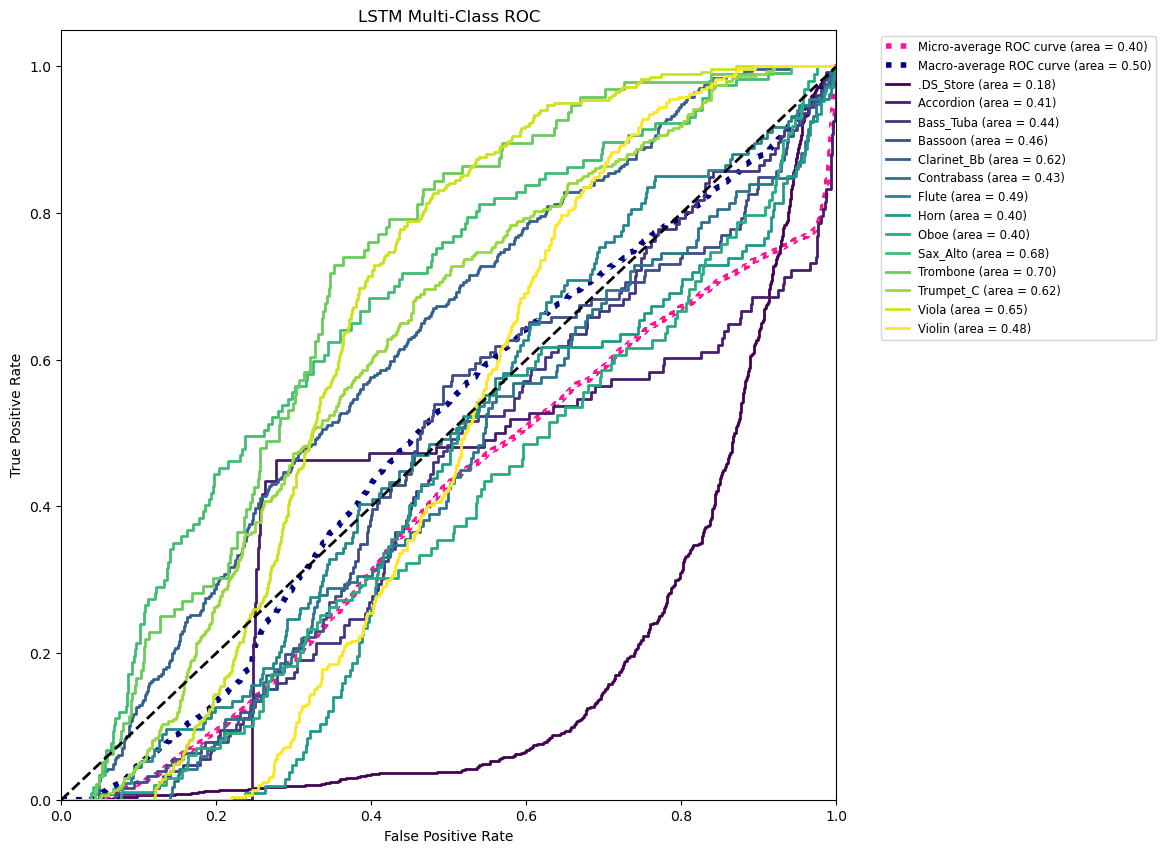

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from tensorflow.keras.utils import to_categorical
import pylab
import seaborn as sns

y_pred = np.load('/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/logs/y_pred.npy')

wav_paths = glob('{}/**'.format('/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/instrument_classification'), recursive=True)
wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x and '.DS_Store' not in x])


classes = sorted(os.listdir('/Users/quanhongjin/Documents/Cornell Tech/CS5785/Porject/instrument_classification'))
labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
le = LabelEncoder()
y_true = le.fit_transform(labels)
y_hot = to_categorical(y_true)
y_pred_le = np.argmax(y_pred, axis=1)
y_pred_labels = [classes[x] for x in y_pred_le]
y_true_labels = [classes[x] for x in y_true]

# Add an extra column of zeros to y_hot to match the model's expected 15 classes
y_hot_expanded = np.zeros((y_hot.shape[0], y_hot.shape[1] + 1))
y_hot_expanded[:,:-1] = y_hot

# Now y_hot_expanded should have the same shape as y_pred
# Use y_hot_expanded for ROC curve calculations


n_classes = len(set(y_true))

# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_hot[:, i], y_pred[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_hot.ravel(), y_pred.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# # First aggregate all false positive rates
# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# # Then interpolate all ROC curves at this points
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# # Finally average it and compute AUC
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# # Plot all ROC curves
# plt.figure(figsize=(10,10))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = []
cm = pylab.get_cmap('nipy_spectral')
for i in range(n_classes):
    color = cm(1.*i/n_classes)
    colors.append(color)
unique_labels = np.unique(labels)

# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='{0} (area = {1:0.2f})'.format(unique_labels[i], roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Multi Class ROC')
# legend = plt.legend()
# legend._legend_box.align = "right"
# plt.legend(loc="lower right")
# plt.show()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_hot_expanded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_hot_expanded.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average the interpolated TPR and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curves for individual classes
colors = pylab.cm.viridis(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

# Plot reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM Multi-Class ROC')
plt.legend(loc="upper left", fontsize='small', bbox_to_anchor=(1.05, 1), ncol=1)
plt.show()


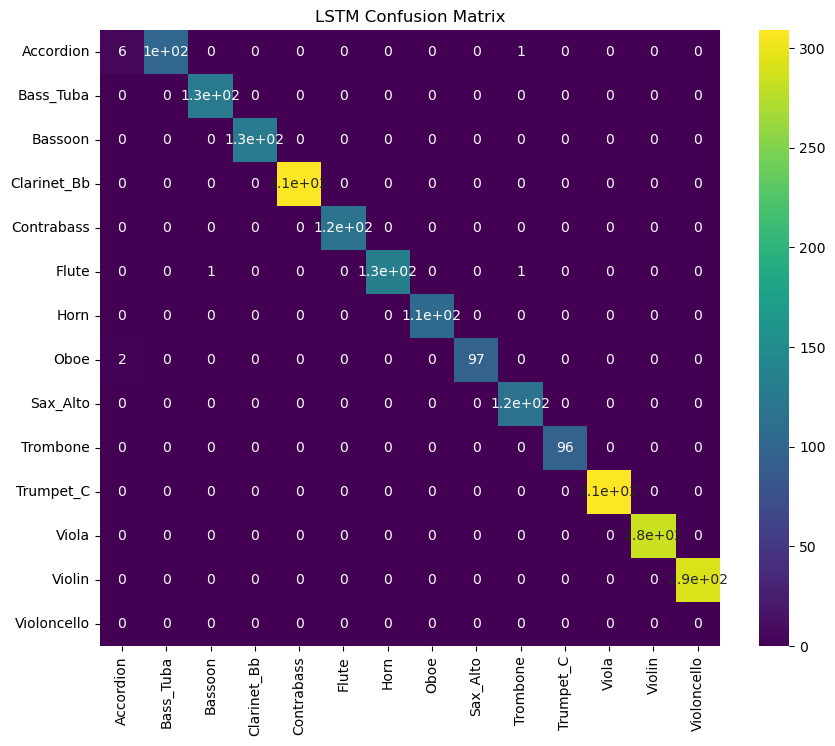

In [43]:
# confusion matrix 
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=unique_labels)
df_cm = pd.DataFrame(conf_mat, index = unique_labels,
                     columns = unique_labels)
plt.figure(figsize = (10,8))
plt.title('LSTM Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()